In [ ]:
# Aqui está sendo instalada as bibliotecas essenciais para projetos com redes neurais e visualização em Python.
# Torch - Usada para criar, treinar e executar redes neurais.
# Torchvision - Biblioteca que faz parte do Pytorch, com ferramentas para visão computacional.
# Matplotlib - Biblioteca para visualização de dados - Gráficos, imagens-

!pip install -q torch torchvision matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 52.9 MB/s eta 0:00:00


In [ ]:
import torch  # Biblioteca principal do PyTorch para tensores e deep learning
import torch.nn as nn # Módulo para definir e treinar redes neurais
import torch.nn.functional as F  # Funções como ReLU, convolução e perdas, usadas diretamente.
import matplotlib.pyplot as plt  # Visualização de imagens e gráficos
import numpy as np  # manipulação de arrays e operações matemáticas
from torchvision import transforms # Conjunto de transformações para pré-processar imagen
from PIL import Image # Leitura e manipulação de imagens
from io import BytesIO # Manipulação de arquivos em memória (como uploads de imagem)
import ipywidgets as widgets  # Criação de widgets interativos no Jupyter Notebook
from IPython.display import display # Mostra widgets e imagens diretamente no notebook
from google.colab import files
import cv2  # Biblioteca para processamento de imagens

Faça upload da máscara de TREINAMENTO e da máscara de TESTE:


Saving mascara_teste.png to mascara_teste.png
Saving mascara_treino.png to mascara_treino.png
Epoch 0, Loss (treino): 0.7312
Epoch 50, Loss (treino): 0.1853
Epoch 100, Loss (treino): 0.0249
Epoch 150, Loss (treino): 0.0161

Loss no conjunto de TESTE: 0.0010


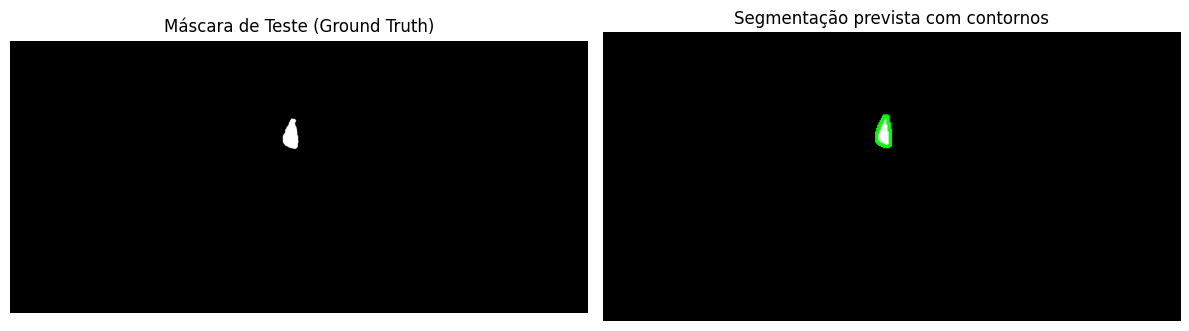

In [ ]:
# 1. Upload das máscaras
print("Faça upload da máscara de TREINAMENTO e da máscara de TESTE:")
uploaded = files.upload()
train_path, test_path = list(uploaded.keys())

# 2. Modelo U-Net Simples
class SimpleUNet(nn.Module):
    def __init__(self):
        super(SimpleUNet, self).__init__()
        self.enc1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)
        self.enc2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec1 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.out_conv = nn.Conv2d(8, 1, kernel_size=1)

    def forward(self, x):
        x1 = F.relu(self.enc1(x))
        x2 = F.relu(self.enc2(self.pool(x1)))
        x3 = F.relu(self.dec1(self.up(x2)))
        x4 = torch.sigmoid(self.out_conv(x3))
        return x4

# 3. Transformação das imagens
transform = transforms.Compose([
    transforms.Resize((256, 512)),
    transforms.ToTensor(),
])

# 4. Carregamento e pré-processamento
train_mask = Image.open(train_path).convert('L')
test_mask = Image.open(test_path).convert('L')

train_input = transform(train_mask).unsqueeze(0)
train_target = (transform(train_mask).unsqueeze(0) > 0.5).float()

test_input = transform(test_mask).unsqueeze(0)
test_target = (transform(test_mask).unsqueeze(0) > 0.5).float()

# 5. Treinamento do modelo
model = SimpleUNet()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(200):
    model.train()
    optimizer.zero_grad()
    output = model(train_input)
    loss = criterion(output, train_target)
    loss.backward()
    optimizer.step()
    if epoch % 50 == 0:
        print(f"Epoch {epoch}, Loss (treino): {loss.item():.4f}")

# 6. Avaliação no conjunto de teste
model.eval()
with torch.no_grad():
    test_output = model(test_input)
    test_loss = criterion(test_output, test_target)
    print(f"\nLoss no conjunto de TESTE: {test_loss.item():.4f}")

# 7. Processamento da predição para visualização
pred_mask = test_output.detach().squeeze().numpy()
pred_binary = (pred_mask > 0.5).astype(np.uint8) * 255

# 8. Encontrar contornos
contours, _ = cv2.findContours(pred_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 9. Converter imagem de teste para BGR
test_resized = np.array(test_mask.resize((512, 256)))
img_color = cv2.cvtColor(test_resized, cv2.COLOR_GRAY2BGR)

# 10. Desenhar contornos em verde
cv2.drawContours(img_color, contours, -1, (0, 255, 0), thickness=2)

# 11. Visualização final
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(test_mask, cmap='gray')
axs[0].set_title("Máscara de Teste (Ground Truth)")
axs[1].imshow(cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB))
axs[1].set_title("Segmentação prevista com contornos")
for ax in axs:
    ax.axis('off')
plt.tight_layout()
plt.show()